# Imports

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Matrcis
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


# XAI
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.inspection import permutation_importance
from interpret.blackbox import LimeTabular
import shap


# Data

The goal of the analysis is to predict work status.

In [141]:
df = pd.read_csv("Job_Placement_Data.csv")
df.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [142]:
df.shape

(215, 13)

## Define response (target) and predictors 

In [143]:
response = "status"

cat_cols = list(df.select_dtypes(exclude="number").columns)
num_cols = list(df.select_dtypes(include="number").columns)

cat_cols.remove(response)

predictors = cat_cols + num_cols

# Missing data

In [30]:
df.isna().sum()

gender                 0
ssc_percentage         0
ssc_board              0
hsc_percentage         0
hsc_board              0
hsc_subject            0
degree_percentage      0
undergrad_degree       0
work_experience        0
emp_test_percentage    0
specialisation         0
mba_percent            0
status                 0
dtype: int64

No missing data

# Visualization

## Response

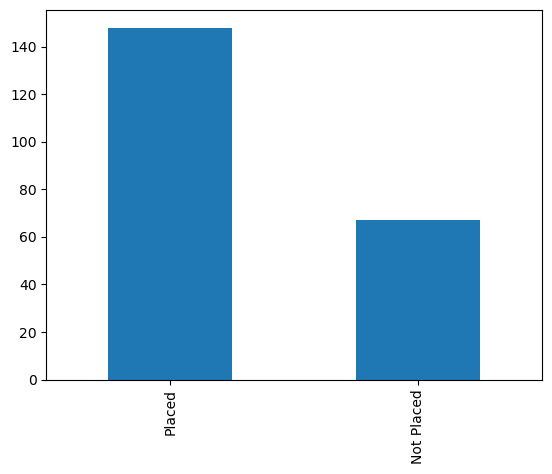

In [11]:
df[response].value_counts().plot(kind = "bar")
plt.show()

## Categorical variables

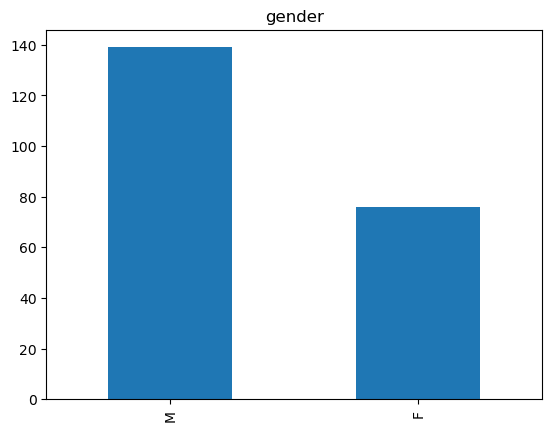

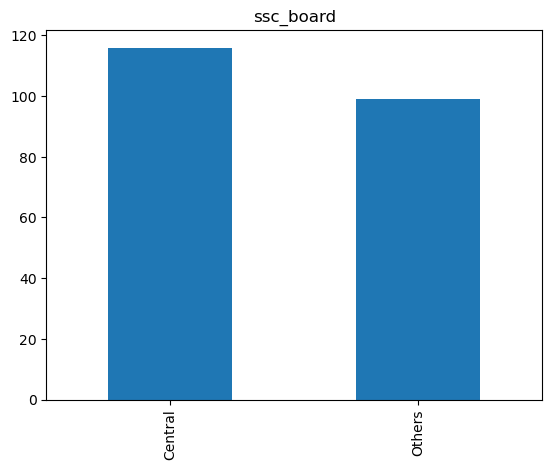

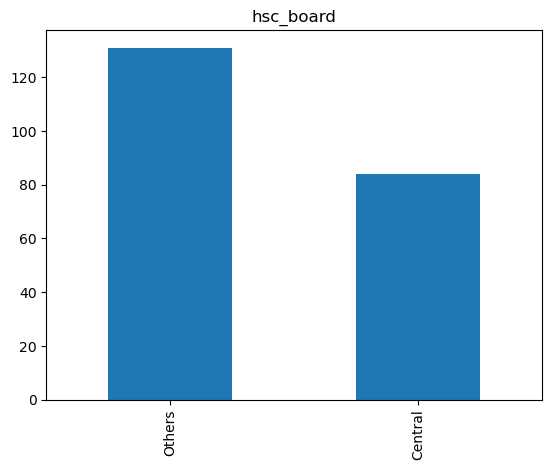

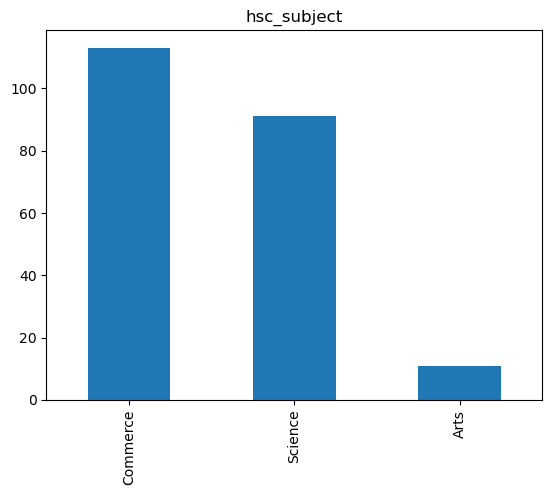

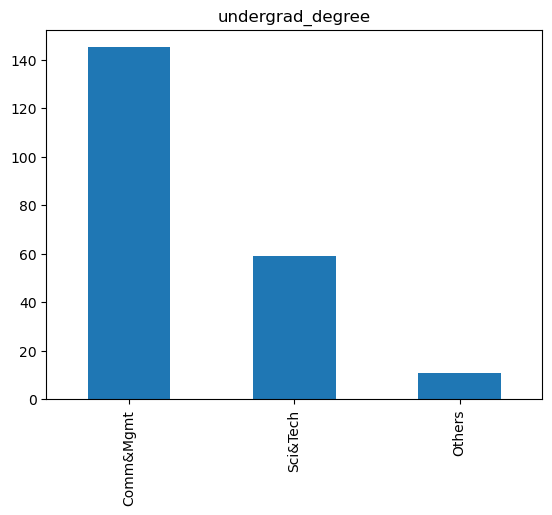

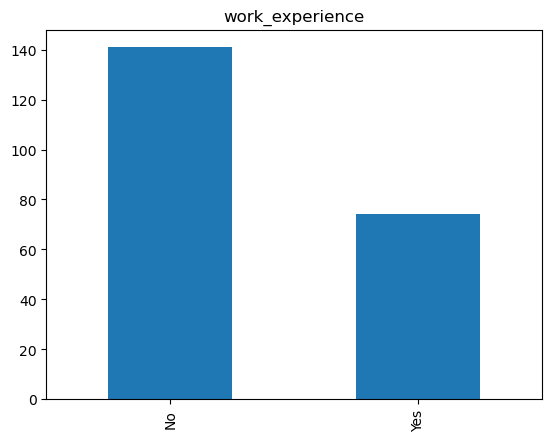

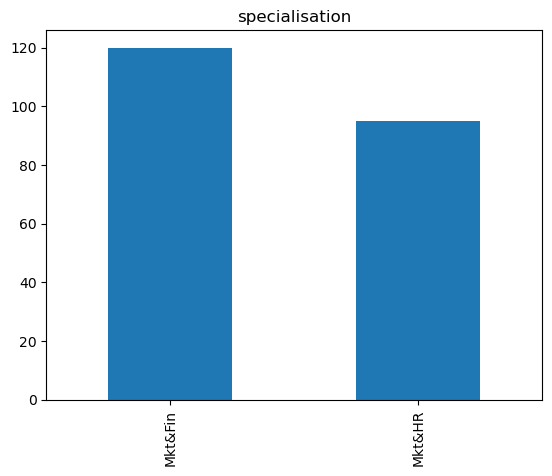

In [24]:
for var in cat_cols:
    plt.title(var)
    df[var].value_counts().plot(kind = "bar")
    plt.show()


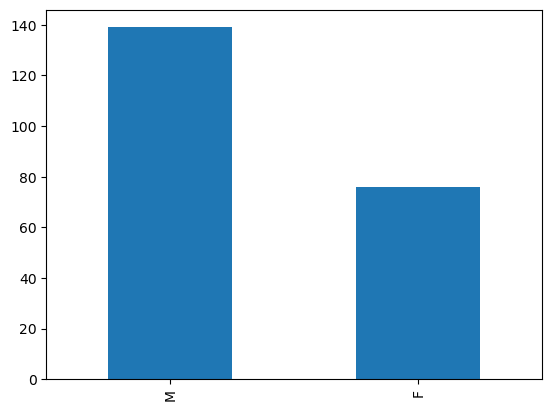

In [12]:
df["gender"].value_counts().plot(kind = "bar")
plt.show()

## Nummerical variables

### Interactions

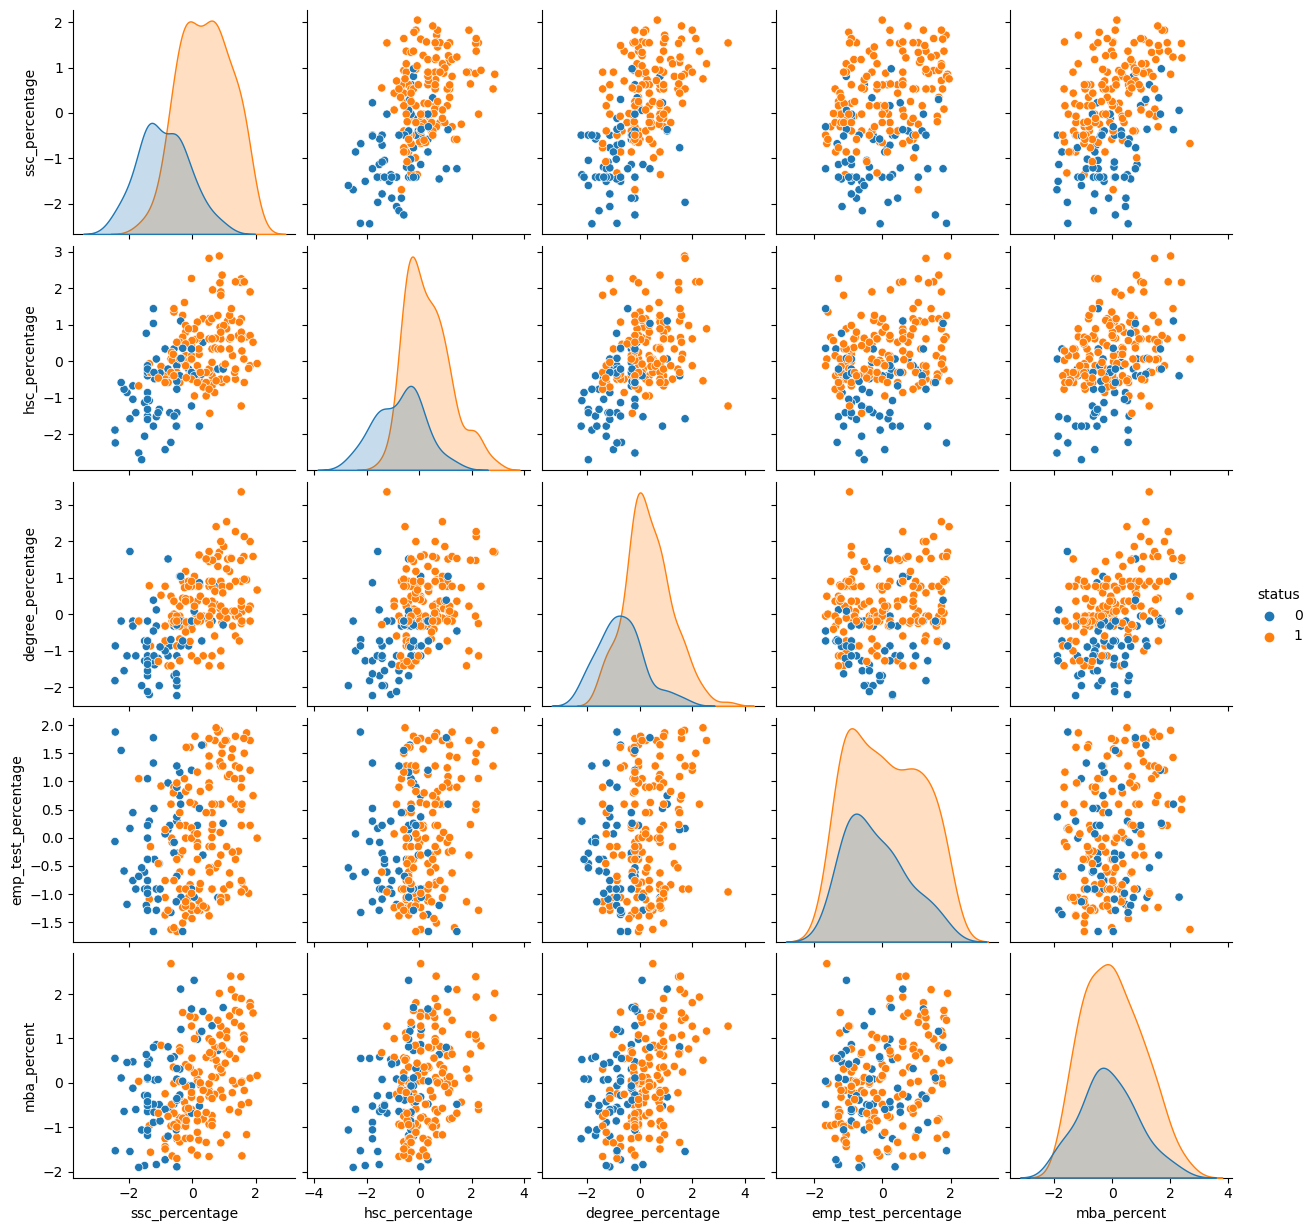

In [44]:
sns.pairplot(df, vars = num_cols, hue = "status")

<AxesSubplot: >

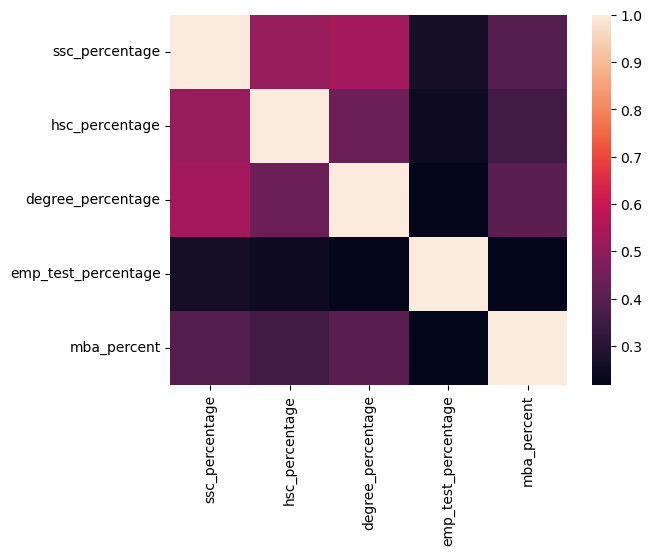

In [23]:
sns.heatmap(df[num_cols].corr())

# Preprocessing

In [14]:
X, y = df.loc[:,predictors], df[response]

In [54]:
response = "status"

cat_cols = df.select_dtypes(exclude="number").columns
num_cols = df.select_dtypes(include="number").columns

predictors = list(cat_cols) + list(num_cols)
predictors.remove(response)

In [16]:
ssc = StandardScaler()
ssc.fit(X[num_cols])
X[num_cols] = ssc.transform(X[num_cols])

X.head()

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,-0.028087,Others,2.268812,Others,Commerce,-1.140102,Sci&Tech,No,-1.291091,Mkt&HR,-0.597647,Placed
1,M,1.113369,Central,1.103448,Others,Science,1.513267,Sci&Tech,Yes,1.087157,Mkt&Fin,0.687620,Placed
2,M,-0.213238,Central,0.153313,Central,Arts,-0.322843,Comm&Mgmt,No,0.218908,Mkt&Fin,-0.769474,Placed
3,M,-1.046417,Central,-1.318339,Central,Science,-1.957362,Sci&Tech,No,-0.460592,Mkt&HR,-0.489396,Not Placed
4,M,1.712332,Central,0.668391,Central,Commerce,0.943909,Comm&Mgmt,No,1.864806,Mkt&Fin,-1.164676,Placed


In [17]:
for col in X.columns:
    if col in cat_cols:
        print(col)
        lbl = LabelEncoder()
        lbl.fit(list(X[col].values))
        X[col] = lbl.transform(list(X[col].values))

lbl = LabelEncoder()
lbl.fit(list(X[col].values))
y = lbl.transform(list(y.values))       

gender
ssc_board
hsc_board
hsc_subject
undergrad_degree
work_experience
specialisation
status


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [53]:
X.head()

,gender,ssc_board,hsc_subject,undergrad_degree,work_experience,specialisation,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent
0,1,1,1,2,0,1,-0.028087,2.268812,-1.140102,-1.291091,-0.597647
1,1,0,2,2,1,0,1.113369,1.103448,1.513267,1.087157,0.687620
2,1,0,0,0,0,0,-0.213238,0.153313,-0.322843,0.218908,-0.769474
3,1,0,2,2,0,1,-1.046417,-1.318339,-1.957362,-0.460592,-0.489396
4,1,0,1,0,0,0,1.712332,0.668391,0.943909,1.864806,-1.164676


# Modeling

## xgBoost

In [51]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)

In [52]:
print("The accuracy is:", accuracy_score(y_test, preds))
print("The f1 score is:", f1_score(y_test, preds))

The accuracy is: 0.8372093023255814
The f1 score is: 0.8923076923076922


## Explainable Boosting Machine

In [45]:
ebm = ExplainableBoostingClassifier(random_state= 1)
ebm.fit(X_train, y_train)

preds = ebm.predict(X_test)

In [46]:
print("Accuracy:", accuracy_score(y_test, preds))
print("F1 score", f1_score(y_test, preds))

Accuracy: 0.813953488372093
F1 score 0.875


In [47]:
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2418458033216/ -->

In [48]:
ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

C:\Users\JoNo1\AppData\Local\Temp\ipykernel_5548\3505171271.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



<!-- http://127.0.0.1:7001/2418711095664/ -->

## Logistic Regression

In [165]:
X, y = df.loc[:,predictors], df[response]

lbl = LabelEncoder()
lbl.fit(list(y.values))
y = lbl.transform(list(y.values))

In [166]:
ssc = StandardScaler()
ssc.fit(X[num_cols])
X[num_cols] = ssc.transform(X[num_cols])

X.head()

,gender,ssc_board,hsc_board,hsc_subject,undergrad_degree,work_experience,specialisation,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent
0,M,Others,Others,Commerce,Sci&Tech,No,Mkt&HR,-0.028087,2.268812,-1.140102,-1.291091,-0.597647
1,M,Central,Others,Science,Sci&Tech,Yes,Mkt&Fin,1.113369,1.103448,1.513267,1.087157,0.687620
2,M,Central,Central,Arts,Comm&Mgmt,No,Mkt&Fin,-0.213238,0.153313,-0.322843,0.218908,-0.769474
3,M,Central,Central,Science,Sci&Tech,No,Mkt&HR,-1.046417,-1.318339,-1.957362,-0.460592,-0.489396
4,M,Central,Central,Commerce,Comm&Mgmt,No,Mkt&Fin,1.712332,0.668391,0.943909,1.864806,-1.164676


In [167]:
for col in cat_cols:
    dummy = pd.get_dummies(X[col], prefix = col, drop_first=True)
    for d_col in dummy.columns:
        X[d_col] = dummy[d_col]
    X = X.drop(col, axis = 1)

X.head()

,ssc_percentage,hsc_percentage,degree_percentage,emp_test_percentage,mba_percent,gender_M,ssc_board_Others,hsc_board_Others,hsc_subject_Commerce,hsc_subject_Science,undergrad_degree_Others,undergrad_degree_Sci&Tech,work_experience_Yes,specialisation_Mkt&HR
0,-0.028087,2.268812,-1.140102,-1.291091,-0.597647,1,1,1,1,0,0,1,0,1
1,1.113369,1.103448,1.513267,1.087157,0.687620,1,0,1,0,1,0,1,1,0
2,-0.213238,0.153313,-0.322843,0.218908,-0.769474,1,0,0,0,0,0,0,0,0
3,-1.046417,-1.318339,-1.957362,-0.460592,-0.489396,1,0,0,0,1,0,1,0,1
4,1.712332,0.668391,0.943909,1.864806,-1.164676,1,0,0,1,0,0,0,0,0


In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Sklearn

In [169]:
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)

preds = log_reg.predict(X_test)

In [170]:
print("The accuracy is:", accuracy_score(y_test, preds))
print("The f1 score is:", f1_score(y_test, preds))

The accuracy is: 0.8837209302325582
The f1 score is: 0.9206349206349206


Performance is even better than the boosting trees

#### Importance plot

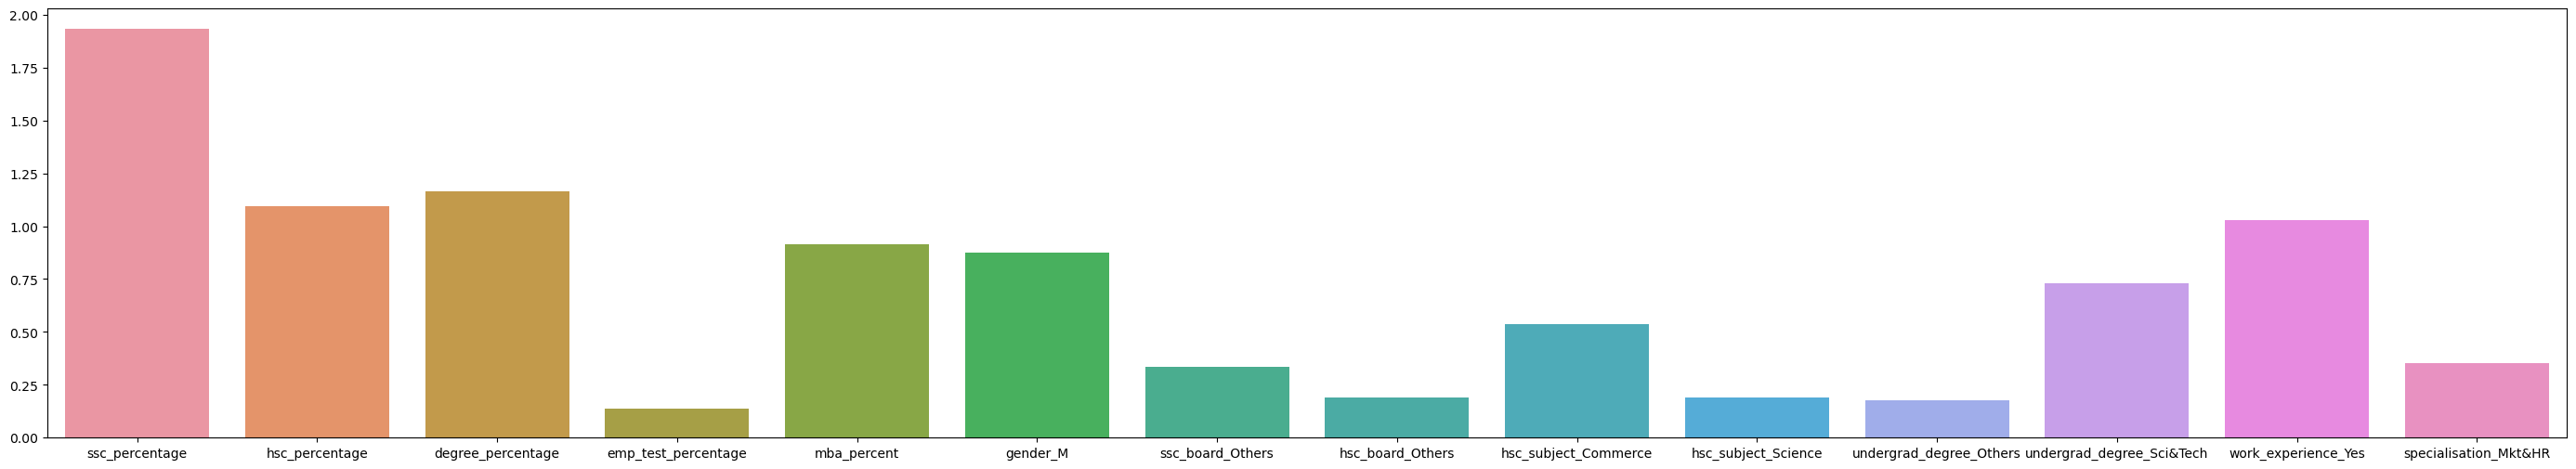

In [173]:
plt.figure(figsize=(35, 6))
names = log_reg.feature_names_in_
values = list(abs(log_reg.coef_[0])) # Take absolute value to find the importance of the variable


sns.barplot(x = names, y = values)
plt.show()

### Statsmodels

Statsmodels give equivalent result. The library provides a usefull summary of the model.

In [174]:
log_reg_sm = sm.Logit(y_train, X_train).fit()

preds = log_reg_sm.predict(X_test)

round_preds = round(preds)

Optimization terminated successfully.
         Current function value: 0.221537
         Iterations 9


In [175]:
print("The accuracy is:", accuracy_score(y_test, round_preds))
print("The f1 score is:", f1_score(y_test, round_preds))

The accuracy is: 0.8837209302325582
The f1 score is: 0.9206349206349206


In [176]:
log_reg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  172
Model:                          Logit   Df Residuals:                      158
Method:                           MLE   Df Model:                           13
Date:                Tue, 24 Jan 2023   Pseudo R-squ.:                  0.6465
Time:                        00:28:38   Log-Likelihood:                -38.104
converged:                       True   LL-Null:                       -107.79
Covariance Type:            nonrobust   LLR p-value:                 2.809e-23
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ssc_percentage                2.7185      0.661      4.114      0.000       1.423       4.014
hsc_percentage                1.4843      0.521      2.849      0.004       0.463       2.505
degree_percentage             1.7886      0.547      3.267      0.001       0.716       2.861
emp_test_percentage          -0.2811      0.380     -0.740      0.459      -1.026       0.464
mba_percent                  -1.2105      0.363     -3.336      0.001      -1.922      -0.499
gender_M                      2.0299      0.800      2.537      0.011       0.462       3.598
ssc_board_Others              0.5678      0.858      0.662      0.508      -1.114       2.250
hsc_board_Others             -0.2081      0.885     -0.235      0.814      -1.943       1.527
hsc_subject_Commerce          0.2826      0.682      0.415      0.678      -1.053       1.618
hsc_subject_Science           0.9010      0.927      0.972      0.331      -0.916       2.718
undergrad_degree_Others       0.6277      1.281      0.490      0.624      -1.883       3.139
undergrad_degree_Sci&Tech    -1.4756      0.887     -1.664      0.096      -3.214       0.263
work_experience_Yes           1.9821      0.720      2.753      0.006       0.571       3.393
specialisation_Mkt&HR        -0.0381      0.658     -0.058      0.954      -1.328       1.252
=============================================================================================
"""

# Interpretation

## Lime

In [36]:
pred_fn = xgb_model.predict_proba

lime = LimeTabular(
    predict_fn = pred_fn,
    data = X_train
)

lime_local = lime.explain_local(X_test[5:], 
                                y_test[5:],
                                name = "LIME")

show(lime_local)

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


<!-- http://127.0.0.1:7001/2418375912992/ -->

## SHAP

In [21]:
model = xgb_model

In [22]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Local explenation

In [32]:
shap.initjs()

prediction = model.predict(X_test)
index = 3 # Index of data point where we give a local explenation


print(f"The RF predicted: {prediction[index]}")
shap.force_plot(explainer.expected_value,
                shap_values[index],
                X_test.iloc[index]) # for values


The RF predicted: 0


### Global explaination

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


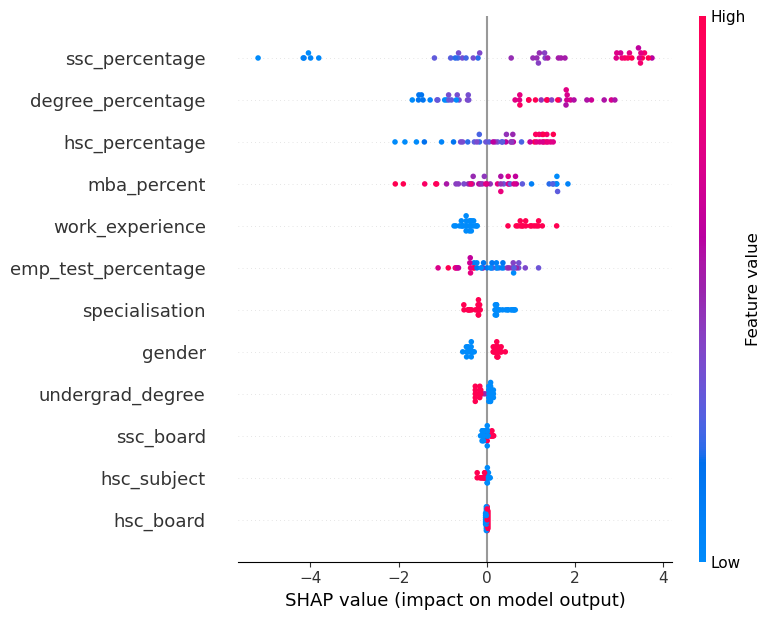

In [24]:
shap.summary_plot(shap_values, X_test)